In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
import torch
print(torch.__version__)


2.5.1+cu118


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [5]:
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

NVIDIA GeForce RTX 4060 Laptop GPU


In [6]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

# print("Path to dataset files:", path)

In [7]:
# import os
# print("Files in the dataset directory:", os.listdir(path))

In [8]:
# ['glioma', 'meningioma', 'notumor', 'pituitary']

In [9]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Transform (resize + convert to tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset
train_dataset = datasets.ImageFolder(root="D:\Programming\Cancer_Detection_Model\Brain_Tumor_Model\Data\Training", transform=transform)

# Class names
classes = train_dataset.classes
print("Classes:", classes)


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


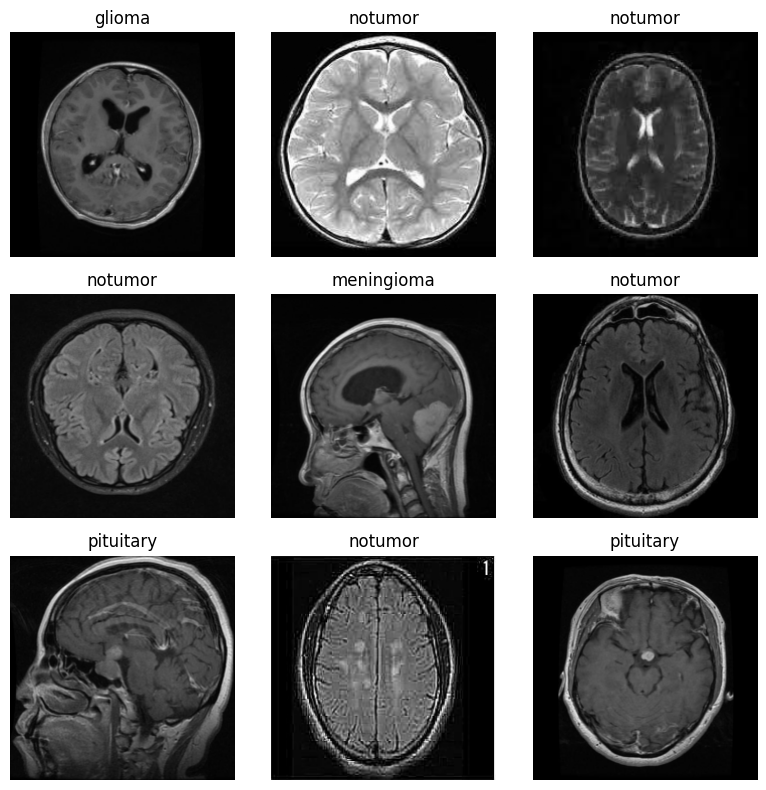

In [10]:
import random
import numpy as np

# Pick 9 random images
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i in range(9):
    idx = random.randint(0, len(train_dataset)-1)
    img, label = train_dataset[idx]

    # Tensor → Numpy for plotting
    img = img.permute(1, 2, 0).numpy()
    
    ax = axes[i//3, i%3]
    ax.imshow(img)
    ax.set_title(classes[label])
    ax.axis("off")

plt.tight_layout()
plt.show()



In [11]:
from collections import Counter

# Folder-wise image counts
labels = [label for _, label in train_dataset]
counter = Counter(labels)

for i, c in enumerate(classes):
    print(f"{c}: {counter[i]} images")


glioma: 1321 images
meningioma: 1339 images
notumor: 1595 images
pituitary: 1457 images


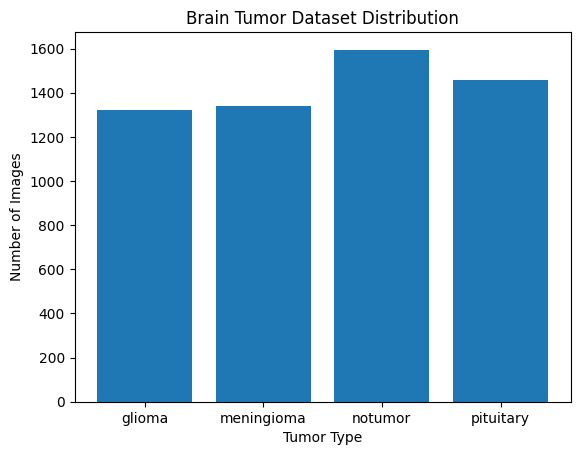

In [12]:
plt.bar(classes, [counter[i] for i in range(len(classes))])
plt.xlabel("Tumor Type")
plt.ylabel("Number of Images")
plt.title("Brain Tumor Dataset Distribution")
plt.show()


In [13]:
from torch.utils.data import DataLoader ,Dataset
from sklearn.model_selection import train_test_split



class CustomImageDataset(Dataset):
    def __init__(self, image_folder):
        self.image_folder = image_folder
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        
    def __len__(self):
        return len(self.image_folder)
    
    def __getitem__(self, idx):
        img, label = self.image_folder[idx]
        img = self.transform(img)
        return img, label

In [14]:
class CNN(torch.nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(64 * 56 * 56, 512)
        self.fc2 = torch.nn.Linear(512, num_classes)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [15]:
learning_rate = 0.001
num_epochs = 10
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
model = CNN(num_classes=len(classes)).to(device)

In [16]:
for param in model.parameters():
    print(param.shape)

torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([512, 200704])
torch.Size([512])
torch.Size([4, 512])
torch.Size([4])


In [17]:
from torch import nn, optim
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [18]:
for ephos in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{ephos+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/10], Loss: 0.8364
Epoch [2/10], Loss: 0.3633
Epoch [3/10], Loss: 0.2460
Epoch [4/10], Loss: 0.1639
Epoch [5/10], Loss: 0.1164
Epoch [6/10], Loss: 0.0830
Epoch [7/10], Loss: 0.0490
Epoch [8/10], Loss: 0.0419
Epoch [9/10], Loss: 0.0358
Epoch [10/10], Loss: 0.0400


In [22]:
# model save
torch.save(model, "model_full.pth")


In [ ]:
model = torch.load("model_full.pth")
model.eval()


In [24]:
# Save the model
# torch.save(model.state_dict(), "brain_tumor_model.pth")

#Prediction
def predict(image_path, model, transform, classes):
    from PIL import Image
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    
    return classes[predicted.item()]

In [25]:
total = 0
correct = 0
test_dataset = datasets.ImageFolder(root="D:\Programming\Cancer_Detection_Model\Brain_Tumor_Model\Data\Testing", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = correct / total
print(f"Test Accuracy: {accuracy*100:.2f}%")

Test Accuracy: 93.14%


In [28]:
#classification report
# input_image =

def classification_report(image_path):
    from PIL import Image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    
    return classes[predicted.item()]

In [29]:
classification_report(r"D:\Programming\Cancer_Detection_Model\Brain_Tumor_Model\Tr-gl_0011.jpg")

'glioma'

In [30]:
classification_report(r"D:\Programming\Cancer_Detection_Model\Brain_Tumor_Model\tummor.png")

'meningioma'